<a href="https://colab.research.google.com/github/IAT-ExploringAI-2024/Week4-Neural_Network/blob/main/Week4__Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [21]:
# from google.colab import drive
# drive.mount('/content/drive')

<center><h1> Introduction to Audio Classification with Neural Networks</h1></center>

# Abstract

### Purpose

This notebook serves as an introduction to working with audio data for classification problems; it is meant as a learning resource rather than a demonstration of the state-of-the-art. The techniques mentioned in this notebook apply not only to classification problems, but to regression problems and problems dealing with other types of input data as well. I focus particularly on feature engineering techniques for audio data and provide an in-depth look at the logic, concepts, and properties of the Multilayer Perceptron (MLP) model, an ancestor and the origin of deep neural networks (DNNs) today. I also provide an introduction to a few key machine learning models and the logic in choosing their hyperparameters. These objectives are framed by the task of recognizing emotion from snippets of speech audio.

### Summary

Data cleansing and feature engineering comprise the most crucial aspect of preparing machine and deep learning models alike and is often the difference between success and failure. We can drastically improve the performance of a model with proper attention paid to feature engineering. This stands for input data which is already useable for predictions; even such data can be transformed in myriad ways to improve predictive performance. For features to be useful in classification they must encompass sufficient variance between different classes. We can further improve the performance of our models by understanding the influence of and precisely tuning their hyperparameters, for which there are algorithmic aids such as Grid Search.

Network architecture is a critical factor in determining the computational complexity of DNNs; often, however, simpler models with just one hidden layer perform better than more complicated models. The importance of proper model evaluation cannot be overstressed: training data should be used strictly for training a model, validation data strictly for tuning a model, and test data strictly to evaluate a model once it is tuned - a model should never be tuned to perform better on test data. To this end, K-Fold Cross Validation is a staple tool.

### Conclusions

Classic machine learning models such as Support Vector Machines (SVM), k Nearest Neighbours (kNN), and Random Forests have distinct advantages to deep neural networks in many tasks but do not match the performance of even the simplest deep neural network in the task of audio classification. The Multilayer Perceptron (MLP) model is the simplest form of DNN suited to classification tasks, provides decent off-the-shelf performance, and can be precisely tuned to be accurate and relatively quick to train.

The MLP provides appreciable accuracy on the RAVDESS dataset, but suffers from the relatively small number of training samples afforded by this dataset. Long Short Term Memory Recurrent Neural Networks (LSTM RNNs) and Convolutional Neural Networks (CNNs) are excellent DNN candidates for audio data classification: LSTM RNNs because of their excellent ability to interpret sequential data such as the audio waveform represented as a time series, and CNNs because features engineered on audio data such as spectrograms have marked resemblance to images, in which CNNs excel at recognition and discrimination between distinct patterns.


<!--TABLE OF CONTENTS-->

# Table of Contents

- [Intro: Speech Emotion Recognition on the RAVDESS dataset](#Intro:-Speech-Emotion-Recognition-on-the-RAVDESS-dataset)
- [Machine Learning Process Overview](#Machine-Learning-Process-Overview)
- [Feature Extraction](#Feature-Extraction)
  - [Load the Dataset and Compute Features](#Load-the-Dataset-and-Compute-Features)
  - [Feature Scaling](#Feature-Scaling)
- [The MLP Model for Classification](#The-MLP-Model-for-Classification)
  - [Choice of Hyperparameters](#Choice-of-Hyperparameters)
  - [Network Architecture](#Network-Architecture)
  - [Hyperparameter Optimization and Grid Search](#Hyperparameter-Optimization-and-Grid-Search)
- [Training and Evaluating the MLP Model](#Training-and-Evaluating-the-MLP-Model)
  - [The Confusion Matrix](#The-Confusion-Matrix)
  - [Precision, Recall, F-Score](#Precision,-Recall,-F-Score)
  - [K-Fold Cross-Validation](#K-Fold-Cross-Validation)
  - [The Validation Curve: Further Tuning of Hyperparameters](#The-Validation-Curve:-Further-Tuning-of-Hyperparameters)
  - [The Learning Curve: Determining Optimal Training Set Size](#The-Learning-Curve:-Determining-Optimal-Training-Set-Size)
- [Higher Complexity DNNs](#Higher-Complexity-DNNs)


## Intro: Speech Emotion Recognition on the RAVDESS dataset

In this notebook we explore the most common machine learning models, specifically those available off the shelf in scikit-learn. After benchmarking performance with machine learning models, we train a Multilayer Perceptron (MLP) model for classification in an attempt to recognize the emotion conveyed in a speech audio snippet. MLP classifiers are a good DNN model to start with because they are simple, flexible, and suited when inputs are assigned a label - in our case, emotion.

I'm going to use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song dataset), created by Steven Livingstone and Frank Russo of Ryerson University. <br>
[Details of the RAVDESS dataset](https://smartlaboratory.org/ravdess/) <br>
[Download the dataset used in this notebook](https://zenodo.org/record/1188976) <br> Scroll half-way down the page and find "Audio_Speech_Actors_01-24"<br>

We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB.
Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences with
a variety of emotions and intensity. We get 1440 speech files (24 actors \* 60 recordings per actor). Each audio sample has been rated by a human 10 times for emotional quality.

## Machine Learning Process Overview

1. Feature Engineering: Choose and define the properties which our model will use to evaluate the audio files. <br>
2. Feature Extraction: Compute the features for each audio file and build a feature matrix representing all audio files. <br>
3. Model exploration: Test candidate models that make sense for the properies of the dataset
4. Training the MLP Classifier model: Choose and optimize the properties of our model on validation data - hyperparameters and architechture. <br>
5. Evaluate our model's performance: Evaluate our model's accuracy on validation data and score it against test data which it has never seen in training.<br>
6. Explore options for improving our model: Is our dataset the right size? Is our model too complex or too simple? <br>


In [22]:
# importing the required libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os

# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings

warnings.filterwarnings("ignore")

## Feature Extraction

We're going to take full advantage of librosa, a Python library enabling audio analysis and feature extraction.
Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC.
Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try
and have bit more discriminatory power between samples. <br>

Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC**: Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40 which I found to work well


In [23]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram = np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram = np.mean(
        librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T, axis=0
    )
    return chromagram


def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = np.mean(
        librosa.feature.melspectrogram(
            y=waveform, sr=sample_rate, n_mels=128, fmax=8000
        ).T,
        axis=0,
    )
    return melspectrogram


def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients = np.mean(
        librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0
    )
    return mfc_coefficients

We're going to wrap our feature extraction functions so we only have to load each audio file once. After extracting our 3 audio features as NumPy arrays representing a time series, we're going to
stack them horizontally to create a single feature array.


In [24]:
def get_features(file):
    # load an individual soundfile
    with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix = np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

### Load the Dataset and Compute Features

We have to understand the labelling of the RAVDESS dataset to find the ground truth emotion for each sample.
Each file is labelled with 7 numbers delimited by a "-".
Most of the numbers describe metadata about the audio samples such as their format (video and/or audio),
whether the audio is a song or statement, which of two statements is being read and by which actor.

The third and fourth numbers pertain to the emotional quality of each sample. The third number is in the range of 1-8 with each number representing an emotion.
The fourth number is either 1 or 2, representing normal (1) or strong (2) emotional intensity.

We're going to define a dictionary based on the third number (emotion) and assign an emotion to each number as specified by the RAVDESS dataset:


In [25]:
# Emotions in the RAVDESS dataset
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

Finally, let's load our entire dataset and compute the features of each audio file:


In [26]:
import os, glob


def load_data():
    X, y = [], []
    count = 0
    for file in glob.glob("MIX/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print("\r" + f" Processed {count}/{1440} audio samples", end=" ")
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

Compute the feature matrix and read the emotion labels for the entire dataset.
Note that our regressor (independent/explanatory variable), usually denoted X, is named 'features', and our regressand (dependent variable), usually denoted y, is named 'emotions'.


In [27]:
features, emotions = load_data()

 Processed 21/1440 audio samples 

 Processed 1435/1440 audio samples 

Let's see what the features we extracted look like, **also for saving both the features matrix as well as emotions array, we need to convert them to pandas dataframe.**


In [28]:
print(f"\nAudio samples represented: {features.shape[0]}")
print(f"Numerical features extracted per sample: {features.shape[1]}")
features_df = pd.DataFrame(features)  # make it pretty for display


# making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions)  # make it pretty for display

features_df


Audio samples represented: 1435
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.552245,0.504338,0.512778,0.550540,0.572176,0.615567,0.603708,0.573230,0.593454,0.603834,...,-3.543537,-0.912676,-1.747536,-2.299447,-0.025205,2.449470,2.116510,3.361054,2.086241,0.376519
1,0.550732,0.508484,0.466810,0.438485,0.428218,0.445352,0.444528,0.444478,0.500419,0.551672,...,2.333152,3.619088,0.793563,0.743431,0.660723,-0.254914,-0.967536,0.378563,-0.338074,-0.463241
2,0.672768,0.601451,0.548317,0.477806,0.453192,0.516665,0.570100,0.599750,0.647746,0.692147,...,0.283253,0.218117,-1.928165,-2.486516,-0.530147,0.354905,0.463640,0.581006,-2.091462,-1.899596
3,0.602309,0.605448,0.558788,0.529441,0.546190,0.568049,0.566027,0.523464,0.526789,0.552809,...,2.176565,3.904047,0.980935,1.160923,-0.694902,-0.969963,-0.234802,0.941700,0.695973,0.430566
4,0.556555,0.503434,0.473118,0.479222,0.495470,0.522489,0.532196,0.540681,0.545616,0.512521,...,-1.306031,0.050261,-0.992539,-0.213367,-0.351018,-1.462262,-2.454565,-1.044800,-0.298479,0.118208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,0.664177,0.633587,0.590743,0.601933,0.623831,0.643299,0.671203,0.668196,0.683204,0.658824,...,5.234397,5.000974,4.120271,3.053777,2.119890,2.965642,2.442994,2.014850,3.167833,4.008449
1431,0.697806,0.658317,0.614802,0.639169,0.717383,0.743908,0.781170,0.749796,0.722322,0.715267,...,-1.211285,0.060299,-1.140080,0.446977,0.614657,0.430341,0.332445,-0.197219,0.797523,2.606972
1432,0.628023,0.596604,0.643935,0.655228,0.659819,0.725635,0.808151,0.814369,0.771093,0.722508,...,-1.125915,0.213711,-1.729091,0.776150,0.564957,2.507703,0.997836,0.844502,-0.108339,2.037053
1433,0.630163,0.652205,0.637307,0.684746,0.764457,0.795282,0.819001,0.802949,0.774911,0.734925,...,-2.221260,-0.709731,-1.652230,-1.931097,-1.620286,1.130693,0.274001,2.252403,2.537369,3.869971


We have a matrix of dim 1435 x 180. Looks good - 1435 audio samples, one per row, with a series of
180 numerical features for each sample.

**Each of the 1435 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.**


Now we will save our features matrix and emotions array in excel file we dont have to compute them everytime we run the notebook, we can just load them from the excel file whenever required. Make sure to change the path to according to your drive.


In [29]:
features_df.to_excel("featuresRavdess.xlsx")
emotions_df.to_excel("emotionsRavdess.xlsx")

## Load pre-saved Dataset


Once saved you only need to load them later by running the cell below, and **skip every cell above** except for the one in which we import libraries.


In [30]:
features = pd.read_excel("featuresRavdess.xlsx", index_col=0)
emotions = pd.read_excel("emotionsRavdess.xlsx", index_col=0)

let's see if they have been loaded correctly!


In [31]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.552245,0.504338,0.512778,0.550540,0.572176,0.615567,0.603708,0.573230,0.593454,0.603834,...,-3.543537,-0.912676,-1.747536,-2.299447,-0.025205,2.449470,2.116510,3.361054,2.086241,0.376519
1,0.550732,0.508484,0.466810,0.438485,0.428218,0.445352,0.444528,0.444478,0.500419,0.551672,...,2.333152,3.619088,0.793563,0.743431,0.660723,-0.254914,-0.967536,0.378563,-0.338074,-0.463241
2,0.672768,0.601451,0.548317,0.477806,0.453192,0.516665,0.570100,0.599750,0.647746,0.692147,...,0.283253,0.218117,-1.928165,-2.486516,-0.530147,0.354905,0.463640,0.581006,-2.091462,-1.899596
3,0.602309,0.605448,0.558788,0.529441,0.546190,0.568049,0.566027,0.523464,0.526789,0.552809,...,2.176565,3.904047,0.980935,1.160923,-0.694902,-0.969963,-0.234802,0.941700,0.695973,0.430566
4,0.556555,0.503434,0.473118,0.479222,0.495470,0.522489,0.532196,0.540681,0.545616,0.512521,...,-1.306031,0.050261,-0.992539,-0.213367,-0.351018,-1.462262,-2.454565,-1.044800,-0.298479,0.118208


Let's see what the features we extracted look like:


In [32]:
print(f"\nAudio samples represented: {features.shape[0]}")
print(f"Numerical features extracted per sample: {features.shape[1]}")
features_df = pd.DataFrame(features)  # make it pretty for display
labels_df = pd.DataFrame(emotions)


Audio samples represented: 1435
Numerical features extracted per sample: 180


We have a matrix of dim 1435 x 180. Looks good - 1435 audio samples, one per row, with a series of
180 numerical features for each sample.

**Each of the 1435 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.**


Let's see the class balance of our dataset:


['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised'] [192 190 192 191 191  96 192 191]


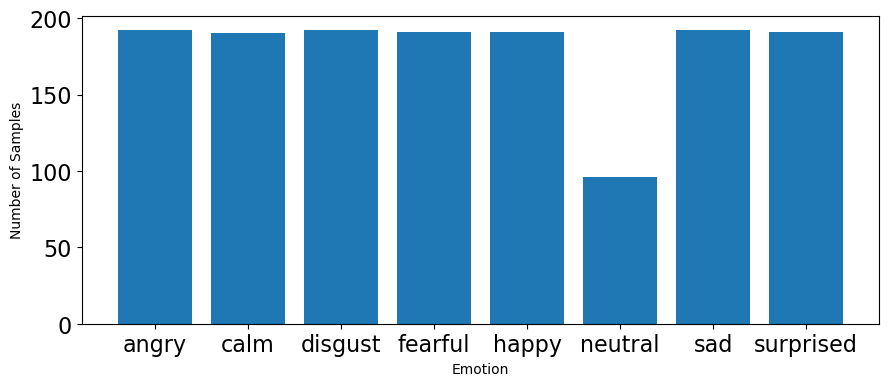

In [33]:
# plot emotions
plt.figure(figsize=(35, 4))
plt.subplot(1, 3, 1)
# np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
print(emotion_list, count)
plt.bar(x=range(8), height=count)
plt.xticks(ticks=range(8), labels=[emotion for emotion in emotion_list], fontsize=10)
plt.xlabel("Emotion")
plt.tick_params(labelsize=16)
plt.ylabel("Number of Samples")
plt.show()

**Great, the classes appear to be balanced. That makes the task easier.** All emotions _except_ the neutral class have a "strong" intensity so there are half as many neutral samples. That might have an impact.


### Feature Scaling

To properly train most machine learning models on _most_ datasets, we first need to scale our features. **This is crucial for models which compute distances between data, and especially critical for DNNs**: If there is a difference in the variance of features simply because of their possible range of values, then a model will learn that the features with the greatest variance are the most important. However, **differences in the variance of unscaled features belonging to different and unknown distributions is an inappropriate measure of importance.** Let's check our features' properties:


In [34]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:, :11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(
        f"12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}"
    )

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:, 12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(
        f"\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}"
    )

    # Check MFCC feature values
    features_df_mfcc = df.loc[:, 140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(
        f"\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}"
    )


print_features(features_df)

12 Chromagram features:           min = 0.310,     max = 0.874,     mean = 0.666,     deviation = 0.085

128 Mel Spectrogram features:     min = 0.000,     max = 149.208,     mean = 0.188,     deviation = 1.600

40 MFCC features:                 min = -873.242,    max = 115.126,    mean = -14.626,    deviation = 98.494


**There's an obvious imbalance in the variance our features; Our features indeed belong to very different distributions:** our MFC coefficients' deviation is greater than the other features by orders of magnitude. That does not mean MFC coefficients are the most important feature, but rather it is a property of the way they are computed. We will certainly need to scale this feature set.

We have the choice of sklearn's StandardScaler and MinMaxScaler. Standard scaling subtracts the mean of each feature and divides it by the standard deviation of that feature, producing features with mean at zero and unit variance - that is, a variance and standard deviation of 1. Min-Max scaling transforms each feature to be within a bounded interval that we specify.

In practice, **MinMax scaling is especially useful when we know our features should be in a bounded interval**, such as pixel values in [0,255], while **standard scaling is perhaps more practical for features with unknown distributions** because centering the features at zero-mean with a standard deviation of 1 means extreme values will have less of an impact on the model's learned weights, i.e. the model is less sensitive to outliers.

We'll create MinMax scaled features as well so we can give them a try later on to confirm that standard scaling is better in the absence of knowledge on the appropriate distribution for a dataset's features.


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

Make sure our features are properly scaled:


In [36]:
print("\033[1m" + "Standard Scaling:\n" + "\033[0m")
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print("\n\n\033[1m" + "MinMax Scaling:\n" + "\033[0m")
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -3.957,     max = 2.645,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 36.480,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.209,    max = 6.240,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.611,     deviation = 0.181

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.015,     deviation = 0.061

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.406,    deviation = 0.166


Perfect. Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling - a default when we don't specify values. We can now move on to building predictive models for these features.


## The MLP Model for Classification

We're going to first try a Multilayer Perceptron (MLP) Classifier, a simple artificial neural network (ANN) model well-suited for predictions trained on labelled inputs. Note that an MLP model can be trained for regression just as well. An MLP network consists of an input layer, _n_ hidden layers, and an output layer. The logic of the network depends on its weights: An array [w<sub>0</sub>-w<sub>i</sub>] for _each node_ in all layers, one weight value for each node-node connection (edge) in the graph representation (a matrix _W_ for the network). We also have biases, an array [b<sub>0</sub>-b<sub>j</sub>] for _each layer_, one value for each node (a matrix _B_ for the network). I'll speak more to its architechture below.


<img src="https://github.com/IAT-ExploringAI-2024/Week4-Neural_Network/blob/main/mlp.png?raw=true" width=500 height=500 />


###Training: The 80/20 Split and Validation
In order to compare models, we'll have to evaluate their performance. The simplest method to do so is to train a model on a portion of our dataset and test it on the remainder. We'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of
the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

More accurately, the proper modality for training and scoring a model is to

1. Fit/train our model on a _training_ set,
2. Evaluate the model on a _validation_ set to tune the hyperparameters for better performance,
3. Finally score our model's true performance - its **generalizability** - against a _test_ set, aka the hold-out set.
4. Repeat from 2. **Do not tune the model to score well on the test set**.

Different set ratios are used in this approach - a usual example is 60/20/20 train/validation/test.

For simplicity, we're going to start with an 80/20 train/test split. The model will be trained on all the training data, and we will check its performance on the test data. Define unscaled and scaled training and test sets:


In [37]:
from sklearn.model_selection import train_test_split

############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    features, emotions, test_size=0.2, random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, emotions, test_size=0.2, random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled, emotions, test_size=0.2, random_state=69
)

### MLP Initialization


We initialize an MLP classification model with random weights and biases at zero, the standard modality. There are techniques for determining optimal weight initialization; the initial distribution of weights is incrediby important because they impact the direction of the gradient and will determine how fast and whether at all a model's loss function will converge.

We'll try the off-the-shelf MLP model that comes with sklearn. Using default settings for neural networks is not a good idea in general - and **checking a model's performance on test data before tuning the model on a validation set is incorrect methodology**... but for demonstrative purposes:


In [38]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(random_state=69)

#################### unscaled features #####################
X_train, X_test, y_train, y_test = train_test_split(
    features, emotions, test_size=0.2, random_state=69
)

model.fit(X_train, y_train)

print(f"Possible emotions predicted by model:{model.classes_}")
print(
    f"Unscaled MLP Model's accuracy on training set is {100*model.score(X_train, y_train):.2f}%"
)
print(
    f"Unscaled MLP Model's accuracy on test set is {100*model.score(X_test, y_test):.2f}%"
)

Possible emotions predicted by model:['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Unscaled MLP Model's accuracy on training set is 67.33%
Unscaled MLP Model's accuracy on test set is 50.52%


Great - we expected terrible performance with no thought given to the model or feature scale. Otherwise, what would a machine learning engineer do? At any rate, we at least know that our model's possible predictions - classes - are correct, and it's even doing a little better than guessing with a 1/8 (12.5%) chance. More than we can ask for with this approach.

Let's see how feature scaling impacts the performance of the MLP:


In [39]:
#################### minmax scaled #######################
# Rebuild the training set from the minmax scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax, emotions, test_size=0.2, random_state=69
)

# Fit the model again on the minmax scaled features
model.fit(X_train_minmax, y_train)

print(
    f"MinMax scaled MLP Model's accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%"
)
print(
    f"MinMax sacled MLP Model's accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%\n"
)

#################### standard scaled #######################
# Rebuild the training set from the standard scaled features
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled, emotions, test_size=0.2, random_state=69
)
# Fit the model again on the scaled features
model.fit(X_train_scaled, y_train)

print(
    f"Standard scaled MLP Model's accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%"
)
print(
    f"Standard scaled MLP Model's accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%"
)

MinMax scaled MLP Model's accuracy on training set is 65.94%
MinMax sacled MLP Model's accuracy on test set is 52.96%

Standard scaled MLP Model's accuracy on training set is 99.65%
Standard scaled MLP Model's accuracy on test set is 67.94%


That's more like it. Standard scaling is indeed the way to go here. **It is important to consider choice of scaling method, if necessary, as a crucial hyperparameter of a model.** Skipping this step or choosing the wrong scaling method can render even the most appropriate features, worthless.

Perhaps with some effort we can make the MLP model work for us. We'll try to give it a fighting chance by actually paying attention to what it's doing:


### Choice of Hyperparameters

Before training a network we must select hyperparameters, which determine the network's learning behaviour - hyperparameters determine how the network learns its weights and biases, while the network parameters determine what those weights and biases are. Each type of model (SVC, MLP, Random Forests, etc...) come with their own set of hyperparameters, and each type of optimization algorithm does as well. We may use the same optimization algorithm for two different models, but memorizing the best hyperparameters for one model won't help us with any other model and likely, not any other task even with the same model.

The MLP model has a number of hyperparameters significant to its learning behaviour:

- **Alpha**: Constrains the model's weights to be within a certain bound to address overfitting; in range [0,1], parameterizes l2 penalty which defines how steeply the cost function modifies weights in proportion to their magnitude, i.e. **regularizes** the cost function and so is also called the regularization term. In practice, **higher alpha more steeply penalizes large weights.**
- **Activation function:** Determines the output of a neuron by the transformation applied to the set of inputs to that neuron
- **Solver:** Algorithm(s) used for optimization of our weights (with backpropogation **gradient descent** in the case of the MLP classifier)
- **Learning rate:** How large of a change the optimization algorithm makes to the model's weights at each training iteration, in
- **Epsilon:** Unique to the 'adam' solver, numerical stability - to avoid divison by zero.

### Network Architecture

The input layer of our MLP neural network is the size of our feature space - that is, one neuron per feature. In our case, 180 input neurons constitute the input layer. Since we are performing multiclass classification, our MLP network has one neuron in its output layer for each class label. In our case 8 output neurons, one per emotion.

The size of our hidden layer is of interest and a more dubious task than choosing other hyperparameters, because the behaviour of different numbers and sizes of hidden layers is much less transparent. There are many opinions on the matter, but there is relative consensus in that **many tasks rarely benefit from more than one hidden layer**, i.e. one hidden layer is sufficient in most cases. The number of neurons in that hidden layer is a less obvious choice, but it seems from literature that a number between the input layer and output layer size is a good starting point. At any rate, the time complexity of training our model scales exponentially with the number of hidden layers, so let's keep that number at the minimum, and likely optimum of 1.

### Hyperparameter Optimization and Grid Search

We're going to take advantage of the grid search cross-validation algorithm to find the best hyperparameters for us.

Grid search is relatively simple to understand - we specify a set of candidate values for each hyperparameter, and grid search tries all combinations of those hyperparameter values to build and score potential models against our training and validation data. Grid search scores sets of hyperparameters by building a validation set from the training set we give it.

We initialize the MLP classifier with the hyperparameters we will keep constant, those less likely to have a significant impact on the model's performance. We shouldn't use grid search to look for hyperparameters we can easily tune later, such as the number of training iterations (# of forward+backward passes through the network for each _batch_ of training samples); if we do so, we significantly inflate the computational cost with little return. For these hyperparameters we should choose values which are usually reasonable from a literature search (...from stackexchange).

In case grid search is too expensive for the hyperparameter grid we specify, **Randomized Grid Search** can be used to sample a fixed number of hyperparameter combinations from the distribution of settings we define.

We define a random state so that we can accurately compare any improvements we make to the model.

We also define a **batch size**: the number of training samples included in one forward (input) and backward (error) pass of the model, which is one **iteration**. A batch size in range [1, #samples] is common - in our case, [1,1440\*0.8]. [**Mini-batches**](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) in the set [32, 64, 128, 256] are usually encouraged, especially on smaller datasets. **Smaller batches** cause more frequent weight updates and faster convergence - faster learning - though each update is less accurate compared to a larger batch. **Larger batches** train on a larger set of inputs simultaneously, and so may optimize loss better at each iteration due to a more accurate gradient computation - however, large batches may encourage overfitting and worsen generalization error.


In [40]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend


# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, emotions, test_size=0.2, random_state=69
)

# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later
    batch_size=256,
    # keep random state constant to accurately compare subsequent models
    random_state=69,
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    "hidden_layer_sizes": [
        (180,),
        (300,),
        (
            100,
            50,
        ),
    ],
    "activation": ["relu", "logistic"],
    "solver": ["sgd", "adam"],
    "alpha": [0.001, 0.01],
    #'epsilon': [1e-08, 0.1],
    "learning_rate": ["adaptive", "constant"],
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models
grid = GridSearchCV(model, parameter_space, cv=10, n_jobs=-1, verbose=10)
# Fit the models specified by the parameter grid
with parallel_backend("multiprocessing"):
    grid.fit(X_train, y_train)


# get the best hyperparameters from grid search object with its best_params_ attribute
print("Best parameters found:\n", grid.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.452 total time=   4.9s
[CV 9/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.522 total time=   8.1s
[CV 10/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.574 total time=   9.5s
[CV 1/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.487 total time=  10.2s
[CV 2/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.470 total time=  10.7s
[CV 3/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.426 total time=  10.8s
[CV 4/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.557 total time=  10.8s
[CV 5/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.530 total time=  10.7s
[CV 6/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.474 total time=  10.8s
[CV 7/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.404 total time=  10.9s
[CV 8/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.583 total time=  11.1s
[CV 9/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.713 total time=  11.3s
[CV 10/10; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.670 total time=  11.2s
[CV 1/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.652 total time=  11.5s
[CV 2/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.583 total time=  11.5s
[CV 3/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.609 total time=  11.5s
[CV 4/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.678 total time=  11.3s
[CV 5/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.678 total time=  11.1s
[CV 6/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.570 total time=  10.7s
[CV 7/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.632 total time=  10.5s
[CV 8/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.452 total time=  10.1s
[CV 9/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.522 total time=  10.3s
[CV 10/10; 3/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.574 total time=  10.3s
[CV 1/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.487 total time=  10.3s
[CV 2/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.470 total time=  10.3s
[CV 3/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.426 total time=  10.5s
[CV 4/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.557 total time=  10.7s
[CV 5/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.530 total time=  10.8s
[CV 6/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.474 total time=  10.6s
[CV 7/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 3/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.404 total time=  11.1s
[CV 8/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.583 total time=  11.1s
[CV 9/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.713 total time=  11.1s
[CV 10/10; 4/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.670 total time=  11.1s
[CV 1/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.652 total time=  11.2s
[CV 2/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.583 total time=  11.0s
[CV 3/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.609 total time=  10.9s
[CV 4/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 7/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.678 total time=  10.6s
[CV 5/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.678 total time=  10.9s
[CV 6/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.570 total time=  10.9s
[CV 7/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 4/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.632 total time=  10.8s
[CV 8/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.513 total time=  13.5s
[CV 9/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.539 total time=  13.9s
[CV 10/10; 5/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.487 total time=  13.9s
[CV 1/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.443 total time=  13.7s
[CV 2/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.530 total time=  14.1s
[CV 3/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.487 total time=  14.1s
[CV 4/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.626 total time=  14.2s
[CV 5/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.513 total time=  14.0s
[CV 6/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.518 total time=  14.1s
[CV 7/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 5/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.482 total time=  14.2s
[CV 8/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.574 total time=  14.2s
[CV 9/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.687 total time=  13.9s
[CV 10/10; 6/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.687 total time=  14.2s
[CV 1/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.687 total time=  14.3s
[CV 2/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.617 total time=  14.2s
[CV 3/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd
[CV 6/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.635 total time=  14.1s
[CV 4/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.713 total time=  14.1s
[CV 5/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.722 total time=  14.0s
[CV 6/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.623 total time=  14.0s
[CV 7/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 6/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.632 total time=  13.8s
[CV 8/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.513 total time=  14.0s
[CV 9/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.539 total time=  14.0s
[CV 10/10; 7/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 3/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.487 total time=  14.0s
[CV 1/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 4/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.530 total time=  13.9s
[CV 2/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.443 total time=  13.9s
[CV 3/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.487 total time=  14.1s
[CV 4/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 7/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.626 total time=  14.0s
[CV 5/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 8/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.513 total time=  13.7s
[CV 6/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.518 total time=  14.1s
[CV 7/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 7/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.482 total time=  14.1s
[CV 8/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 1/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.574 total time=  14.1s
[CV 9/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 2/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.687 total time=  14.1s
[CV 10/10; 8/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.687 total time=  14.2s
[CV 1/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.687 total time=  14.1s
[CV 2/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.635 total time=  13.6s
[CV 3/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.617 total time=  14.0s
[CV 4/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.713 total time=  13.8s
[CV 5/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.722 total time=  13.3s
[CV 6/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 9/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.623 total time=  13.2s
[CV 7/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 10/10; 8/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.632 total time=  13.2s
[CV 8/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.461 total time=  14.0s
[CV 9/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.487 total time=  12.6s
[CV 10/10; 9/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.461 total time=  11.8s
[CV 1/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.452 total time=  12.0s
[CV 2/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.426 total time=  11.8s
[CV 3/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.461 total time=  11.5s
[CV 4/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 7/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.548 total time=  11.4s
[CV 5/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam
[CV 8/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.504 total time=  11.4s
[CV 6/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.465 total time=  11.4s
[CV 7/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 9/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.553 total time=  11.5s
[CV 8/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.591 total time=  11.3s
[CV 9/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.678 total time=  11.6s
[CV 10/10; 10/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.617 total time=  11.7s
[CV 1/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 4/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.565 total time=  11.6s
[CV 2/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 5/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.600 total time=  11.6s
[CV 3/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 6/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.574 total time=  11.5s
[CV 4/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.704 total time=  11.5s
[CV 5/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.704 total time=  11.6s
[CV 6/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.588 total time=  11.3s
[CV 7/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 10/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.702 total time=  11.6s
[CV 8/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.461 total time=  11.6s
[CV 9/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 2/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.487 total time=  11.5s
[CV 10/10; 11/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 3/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.461 total time=  11.5s
[CV 1/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 4/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.452 total time=  11.5s
[CV 2/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.426 total time=  11.3s
[CV 3/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.461 total time=  11.4s
[CV 4/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 7/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.548 total time=  11.1s
[CV 5/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.504 total time=  11.3s
[CV 6/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.465 total time=  11.4s
[CV 7/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 10/10; 11/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.553 total time=  11.4s
[CV 8/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 2/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.678 total time=  11.4s
[CV 9/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.591 total time=  11.5s
[CV 10/10; 12/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.617 total time=  11.4s
[CV 1/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.600 total time=  11.5s
[CV 2/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 4/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.565 total time=  11.8s
[CV 3/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.574 total time=  11.9s
[CV 4/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.704 total time=  12.2s
[CV 5/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 8/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.704 total time=  12.4s
[CV 6/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 9/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.588 total time=  12.4s
[CV 7/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 10/10; 12/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.702 total time=  12.4s
[CV 8/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 1/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.452 total time=   8.4s
[CV 9/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.530 total time=   9.2s
[CV 10/10; 13/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.574 total time=   9.6s
[CV 1/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.487 total time=   9.8s
[CV 2/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.470 total time=  10.0s
[CV 3/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.426 total time=  10.1s
[CV 4/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam
[CV 7/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.557 total time=  10.1s
[CV 5/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 8/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.530 total time=  10.1s
[CV 6/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam
[CV 9/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.474 total time=  10.1s
[CV 7/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 13/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.404 total time=   9.9s
[CV 8/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.583 total time=  10.4s
[CV 9/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.696 total time=  10.3s
[CV 10/10; 14/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.661 total time=  10.4s
[CV 1/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 4/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.661 total time=  10.4s
[CV 2/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd
[CV 5/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.583 total time=  10.3s
[CV 3/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.617 total time=  10.5s
[CV 7/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.687 total time=  10.4s
[CV 4/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd
[CV 5/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.670 total time=  10.3s
[CV 6/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.579 total time=  10.5s
[CV 7/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 14/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.632 total time=  10.4s
[CV 8/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.452 total time=  10.3s
[CV 9/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 3/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.574 total time=  10.3s
[CV 10/10; 15/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd
[CV 2/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.530 total time=  10.3s
[CV 1/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.470 total time=  10.2s
[CV 2/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 4/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.487 total time=  10.2s
[CV 3/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.426 total time=   9.9s
[CV 4/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.557 total time=  10.2s
[CV 5/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.530 total time=  10.0s
[CV 6/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.474 total time=  10.1s
[CV 7/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 15/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.404 total time=  10.1s
[CV 8/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 1/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.583 total time=  10.2s
[CV 9/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 2/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.696 total time=  10.1s
[CV 10/10; 16/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.661 total time=  10.2s
[CV 1/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.661 total time=  10.4s
[CV 2/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.583 total time=  11.0s
[CV 3/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.617 total time=  11.4s
[CV 4/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.687 total time=  11.8s
[CV 5/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.670 total time=  12.1s
[CV 6/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 9/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.579 total time=  12.1s
[CV 7/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 10/10; 16/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.632 total time=  12.1s
[CV 8/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.513 total time=  14.7s
[CV 9/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.539 total time=  14.4s
[CV 10/10; 17/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.487 total time=  14.7s
[CV 1/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.530 total time=  14.4s
[CV 2/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.443 total time=  14.0s
[CV 3/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.487 total time=  13.9s
[CV 4/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam
[CV 8/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.513 total time=  13.8s
[CV 5/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.626 total time=  14.1s
[CV 6/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.509 total time=  14.1s
[CV 7/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 17/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.482 total time=  13.7s
[CV 8/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.574 total time=  14.4s
[CV 9/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.670 total time=  14.3s
[CV 10/10; 18/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.678 total time=  14.3s
[CV 1/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 4/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.687 total time=  14.2s
[CV 2/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd
[CV 5/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.617 total time=  14.2s
[CV 3/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.626 total time=  14.3s
[CV 4/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.704 total time=  14.4s
[CV 5/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.722 total time=  13.9s
[CV 6/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.614 total time=  14.3s
[CV 7/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 18/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.632 total time=  14.3s
[CV 8/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.513 total time=  14.2s
[CV 9/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 2/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.539 total time=  14.2s
[CV 10/10; 19/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd
[CV 3/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.487 total time=  14.1s
[CV 1/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.530 total time=  14.2s
[CV 2/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.443 total time=  14.2s
[CV 3/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.487 total time=  13.7s
[CV 4/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.626 total time=  14.1s
[CV 5/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.513 total time=  14.0s
[CV 6/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.509 total time=  14.1s
[CV 7/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 10/10; 19/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.482 total time=  13.9s
[CV 8/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 1/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.574 total time=  14.1s
[CV 9/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.670 total time=  14.1s
[CV 10/10; 20/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.678 total time=  14.1s
[CV 1/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.687 total time=  13.9s
[CV 2/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.617 total time=  13.9s
[CV 3/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.626 total time=  13.8s
[CV 4/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.704 total time=  13.5s
[CV 5/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 8/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.722 total time=  13.1s
[CV 6/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 9/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.614 total time=  13.0s
[CV 7/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 20/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.632 total time=  13.0s
[CV 8/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.461 total time=  14.1s
[CV 9/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.496 total time=  13.1s
[CV 10/10; 21/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.461 total time=  12.3s
[CV 1/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.452 total time=  12.0s
[CV 2/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.426 total time=  11.7s
[CV 3/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.461 total time=  11.5s
[CV 7/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.539 total time=  11.4s
[CV 4/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam
[CV 5/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.504 total time=  11.5s
[CV 6/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.465 total time=  11.5s
[CV 7/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 21/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.553 total time=  11.2s
[CV 8/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.591 total time=  11.6s
[CV 9/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.696 total time=  11.7s
[CV 10/10; 22/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.626 total time=  11.6s
[CV 1/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.600 total time=  11.5s
[CV 2/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 4/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.591 total time=  11.6s
[CV 3/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.591 total time=  11.7s
[CV 4/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.687 total time=  11.6s
[CV 5/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.713 total time=  11.3s
[CV 6/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.588 total time=  11.5s
[CV 7/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 22/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.693 total time=  11.6s
[CV 8/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.461 total time=  11.5s
[CV 9/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 2/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.496 total time=  11.4s
[CV 10/10; 23/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 3/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.461 total time=  11.4s
[CV 1/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.452 total time=  11.5s
[CV 2/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.426 total time=  11.6s
[CV 3/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 6/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.461 total time=  11.3s
[CV 4/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.539 total time=  11.9s
[CV 5/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.504 total time=  12.1s
[CV 6/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.465 total time=  12.1s
[CV 7/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 10/10; 23/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.553 total time=  12.1s
[CV 8/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 1/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.591 total time=  12.1s
[CV 9/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.696 total time=  12.2s
[CV 10/10; 24/48] START activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 4/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.591 total time=  11.9s
[CV 1/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 3/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.626 total time=  12.2s
[CV 2/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.600 total time=  13.2s
[CV 3/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.591 total time=  13.2s
[CV 4/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.687 total time=  13.4s
[CV 5/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 8/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.713 total time=  13.4s
[CV 6/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 9/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.588 total time=  13.4s
[CV 7/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.261 total time=   9.4s
[CV 8/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 10/10; 24/48] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.693 total time=  13.7s
[CV 9/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 2/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.313 total time=   9.7s
[CV 10/10; 25/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.426 total time=   9.9s
[CV 1/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.304 total time=  10.0s
[CV 2/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.365 total time=  10.2s
[CV 3/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.313 total time=  10.2s
[CV 4/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam
[CV 7/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.417 total time=  10.2s
[CV 5/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.278 total time=  10.1s
[CV 6/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 9/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.316 total time=  10.3s
[CV 7/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam
[CV 10/10; 25/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.307 total time=  10.4s
[CV 8/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.470 total time=  10.5s
[CV 9/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.539 total time=  10.6s
[CV 10/10; 26/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  10.6s
[CV 1/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 4/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.478 total time=  10.6s
[CV 2/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd
[CV 5/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  10.5s
[CV 3/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.470 total time=  10.4s
[CV 4/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 7/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.539 total time=  10.6s
[CV 5/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd
[CV 8/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  10.6s
[CV 6/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.526 total time=  10.5s
[CV 7/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 26/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.447 total time=  10.5s
[CV 8/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.261 total time=  10.4s
[CV 9/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 2/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.313 total time=  10.4s
[CV 10/10; 27/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd
[CV 3/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.426 total time=  10.4s
[CV 1/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 4/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.304 total time=  10.0s
[CV 2/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.365 total time=  10.3s
[CV 3/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 6/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.313 total time=  10.4s
[CV 4/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.417 total time=  10.8s
[CV 5/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.278 total time=  11.2s
[CV 6/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.316 total time=  11.5s
[CV 7/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 10/10; 27/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.307 total time=  11.5s
[CV 8/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 2/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.539 total time=  11.4s
[CV 9/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 1/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.470 total time=  11.6s
[CV 10/10; 28/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 3/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.496 total time=  11.6s
[CV 1/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 4/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.478 total time=  11.6s
[CV 2/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.496 total time=  11.6s
[CV 3/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.470 total time=  11.2s
[CV 4/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.539 total time=  11.1s
[CV 5/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.526 total time=  10.7s
[CV 6/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 8/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.496 total time=  11.1s
[CV 7/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 10/10; 28/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.447 total time=  11.0s
[CV 8/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 1/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.270 total time=  14.0s
[CV 2/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.391 total time=  13.9s
[CV 9/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 10/10; 29/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.374 total time=  14.5s
[CV 1/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.383 total time=  14.4s
[CV 2/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.357 total time=  14.3s
[CV 3/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.374 total time=  14.2s
[CV 4/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 7/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.435 total time=  14.4s
[CV 5/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam
[CV 8/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.322 total time=  14.4s
[CV 6/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 10/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.298 total time=  14.4s
[CV 7/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam
[CV 9/10; 29/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.307 total time=  14.4s
[CV 8/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.487 total time=  14.2s
[CV 9/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.557 total time=  14.3s
[CV 10/10; 30/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.478 total time=  13.9s
[CV 1/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.522 total time=  14.4s
[CV 2/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.461 total time=  14.3s
[CV 3/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd
[CV 5/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  14.4s
[CV 4/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 7/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.548 total time=  14.3s
[CV 5/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd
[CV 8/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.513 total time=  14.4s
[CV 6/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.535 total time=  14.3s
[CV 7/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 30/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.500 total time=  14.2s
[CV 8/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.270 total time=  13.7s
[CV 9/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.391 total time=  14.1s
[CV 10/10; 31/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 3/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.374 total time=  14.1s
[CV 1/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 4/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.383 total time=  14.1s
[CV 2/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.357 total time=  14.0s
[CV 3/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 6/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.374 total time=  14.0s
[CV 4/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.435 total time=  14.1s
[CV 5/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.322 total time=  14.1s
[CV 6/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.307 total time=  13.7s
[CV 7/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 31/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.298 total time=  14.1s
[CV 8/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 1/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.487 total time=  14.2s
[CV 9/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 2/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.557 total time=  14.2s
[CV 10/10; 32/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 3/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.522 total time=  14.4s
[CV 1/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 4/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.478 total time=  14.3s
[CV 2/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.496 total time=  13.9s
[CV 3/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 7/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.548 total time=  13.4s
[CV 4/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 6/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.461 total time=  13.8s
[CV 5/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.513 total time=  13.4s
[CV 6/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer:

[CV 9/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.535 total time=  13.2s
[CV 7/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 1/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.157 total time=   8.8s
[CV 8/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 10/10; 32/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.500 total time=  13.3s
[CV 9/10; 33/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 2/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.174 total time=   9.2s
[CV 10/10; 33/48] START a

/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.165 total time=   5.7s
[CV 1/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.139 total time=   6.2s
[CV 2/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.191 total time=   7.4s
[CV 3/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.149 total time=   7.7s
[CV 4/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.139 total time=   8.4s
[CV 5/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.139 total time=   8.9s
[CV 6/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.191 total time=  11.9s
[CV 7/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam
[CV 10/10; 33/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.184 total time=  11.4s
[CV 8/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.461 total time=  11.7s
[CV 9/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 2/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.504 total time=  11.8s
[CV 10/10; 34/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam
[CV 3/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.530 total time=  11.8s
[CV 1/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.443 total time=  11.7s
[CV 2/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.513 total time=  11.5s
[CV 3/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 1/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.130 total time=   3.3s
[CV 4/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.496 total time=  11.5s
[CV 5/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 4/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.165 total time=   2.5s
[CV 6/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y

[CV 7/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.548 total time=  11.6s
[CV 7/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 2/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.174 total time=   3.5s
[CV 8/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 5/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.183 total time=   2.6s
[CV 9/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y

[CV 8/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.470 total time=  11.6s
[CV 10/10; 35/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 3/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.200 total time=   3.5s
[CV 1/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 9/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.140 total time=   3.8s
[CV 2/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 9/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.518 total time=  11.2s
[CV 3/10; 36/48] 

/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.139 total time=   4.9s
[CV 4/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y

[CV 10/10; 34/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.456 total time=  11.5s
[CV 5/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 8/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.139 total time=   5.1s
[CV 6/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 10/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.158 total time=   7.7s
[CV 7/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 35/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.191 total time=  11.3s
[CV 8/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.461 total time=  11.3s
[CV 9/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.530 total time=  11.1s
[CV 10/10; 36/48] START activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.504 total time=  11.4s
[CV 1/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.443 total time=  11.5s
[CV 2/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 5/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.513 total time=  11.5s
[CV 3/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 6/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.496 total time=  11.4s
[CV 4/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.548 total time=  11.8s
[CV 5/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.470 total time=  12.5s
[CV 6/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.261 total time=   8.7s
[CV 7/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.518 total time=  12.6s
[CV 8/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.313 total time=   8.9s
[CV 9/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 3/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.426 total time=   8.9s
[CV 10/10; 37/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 4/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.304 total time=   8.9s
[CV 1/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 36/48] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.456 total time=  13.3s
[CV 2/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.365 total time=   9.3s
[CV 3/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.313 total time=   9.7s
[CV 4/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.417 total time=   9.8s
[CV 5/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.278 total time=   9.8s
[CV 6/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.316 total time=   9.9s
[CV 7/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 10/10; 37/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.307 total time=  10.0s
[CV 8/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam
[CV 1/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.461 total time=  10.1s
[CV 9/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.539 total time=  10.2s
[CV 10/10; 38/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  10.4s
[CV 1/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.478 total time=  10.5s
[CV 2/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.504 total time=  10.5s
[CV 3/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.461 total time=  10.5s
[CV 4/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.548 total time=  10.5s
[CV 5/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  10.4s
[CV 6/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.518 total time=  10.5s
[CV 7/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 38/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.447 total time=  10.0s
[CV 8/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.261 total time=  10.2s
[CV 9/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.313 total time=  10.1s
[CV 10/10; 39/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.426 total time=  10.2s
[CV 1/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.304 total time=  10.1s
[CV 2/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.365 total time=  10.2s
[CV 3/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.313 total time=  10.2s
[CV 4/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.417 total time=  10.2s
[CV 5/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.278 total time=  10.0s
[CV 6/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.316 total time=  10.2s
[CV 7/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 39/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=sgd;, score=0.307 total time=  10.3s
[CV 8/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 1/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.461 total time=  10.4s
[CV 9/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam
[CV 2/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.539 total time=  10.3s
[CV 10/10; 40/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.496 total time=  10.3s
[CV 1/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 4/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.478 total time=  10.3s
[CV 2/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.504 total time=  10.4s
[CV 3/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.461 total time=  10.2s
[CV 4/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.548 total time=  10.6s
[CV 5/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.496 total time=  10.9s
[CV 6/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 9/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.518 total time=  10.9s
[CV 7/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 10/10; 40/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(180,), learning_rate=constant, solver=adam;, score=0.447 total time=  10.9s
[CV 8/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 1/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.270 total time=  13.8s
[CV 9/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd
[CV 2/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.391 total time=  13.8s
[CV 10/10; 41/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.374 total time=  13.7s
[CV 1/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.383 total time=  13.6s
[CV 2/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.357 total time=  14.0s
[CV 3/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.374 total time=  14.3s
[CV 4/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 7/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.435 total time=  14.3s
[CV 5/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam
[CV 8/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.322 total time=  14.2s
[CV 6/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.307 total time=  14.2s
[CV 7/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 41/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=sgd;, score=0.298 total time=  14.4s
[CV 8/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.496 total time=  14.4s
[CV 9/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.539 total time=  13.9s
[CV 10/10; 42/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.530 total time=  14.5s
[CV 1/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.478 total time=  14.6s
[CV 2/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 6/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.452 total time=  14.4s
[CV 3/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd
[CV 5/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.504 total time=  14.5s
[CV 4/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.548 total time=  14.5s
[CV 5/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.513 total time=  14.5s
[CV 6/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.526 total time=  14.5s
[CV 7/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 42/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=adaptive, solver=adam;, score=0.509 total time=  14.0s
[CV 8/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.270 total time=  14.4s
[CV 9/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.391 total time=  14.4s
[CV 10/10; 43/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 3/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.374 total time=  14.3s
[CV 1/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam
[CV 4/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.383 total time=  14.4s
[CV 2/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.357 total time=  14.2s
[CV 3/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.374 total time=  14.3s
[CV 4/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.435 total time=  14.4s
[CV 5/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.322 total time=  14.0s
[CV 6/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.307 total time=  14.4s
[CV 7/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 43/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=sgd;, score=0.298 total time=  14.3s
[CV 8/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.496 total time=  14.4s
[CV 9/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.539 total time=  14.6s
[CV 10/10; 44/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.530 total time=  15.2s
[CV 1/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.478 total time=  15.2s
[CV 2/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.504 total time=  15.3s
[CV 3/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.452 total time=  14.8s
[CV 4/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 7/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.548 total time=  14.9s
[CV 5/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.513 total time=  14.0s
[CV 6/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 4/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.165 total time=   7.3s
[CV 7/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 1/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.157 total time=   8.7s
[CV 8/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer:

[CV 9/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.526 total time=  13.7s
[CV 9/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 10/10; 44/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(300,), learning_rate=constant, solver=adam;, score=0.509 total time=  13.5s
[CV 10/10; 45/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd
[CV 2/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.174 total time=   8.9s
[CV 1/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.191 total time=   8.7s
[CV 2/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.139 total time=   6.8s
[CV 3/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 9/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.149 total time=   7.8s
[CV 7/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.139 total time=   8.4s
[CV 4/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam
[CV 5/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.139 total time=   9.0s
[CV 6/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y

[CV 6/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.191 total time=  11.9s
[CV 7/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam
[CV 10/10; 45/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd;, score=0.184 total time=  11.4s
[CV 8/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.452 total time=  11.8s
[CV 9/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.478 total time=  11.8s
[CV 10/10; 46/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.522 total time=  11.8s
[CV 1/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 1/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.130 total time=   3.2s
[CV 2/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.513 total time=  11.2s
[CV 3/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.443 total time=  11.5s
[CV 4/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.496 total time=  11.6s
[CV 5/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 2/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.174 total time=   3.5s
[CV 6/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.165 total time=   2.4s
[CV 7/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.200 total time=   3.4s
[CV 8/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y

[CV 7/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.539 total time=  11.5s
[CV 9/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 5/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.183 total time=   2.6s
[CV 10/10; 47/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd
[CV 8/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.470 total time=  11.5s
[CV 1/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

[CV 9/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.518 total time=  11.5s
[CV 2/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 10/10; 46/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam;, score=0.456 total time=  11.4s
[CV 3/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 7/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.139 total time=   4.8s
[CV 4/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 9/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.140 total time=   3.8s
[CV 5/10; 48/48] START 

/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 8/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.139 total time=   4.9s
[CV 6/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 10/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.158 total time=   7.6s
[CV 7/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 6/10; 47/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd;, score=0.191 total time=  11.3s
[CV 8/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.452 total time=  11.4s
[CV 9/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.478 total time=  11.4s
[CV 10/10; 48/48] START activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam
[CV 3/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.522 total time=  11.4s


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.443 total time=  10.9s
[CV 5/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.513 total time=  11.0s


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 6/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.496 total time=  10.5s


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 7/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.539 total time=   8.9s


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 8/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.470 total time=   7.7s


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 9/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.518 total time=   6.1s
[CV 10/10; 48/48] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam;, score=0.456 total time=   5.6s
Best parameters found:
 {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'solver': 'adam'}


#### RELU Activation Function

Grid search chose the (Rectified Linear Unit) relu function as the best activation function The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back. So it can be written as f(x)=max(0,x). While our **hidden layer use the relu function** for its activation on each neuron, our **output layer will necessarily use the softmax function** - an exponential normalization function - in order to scale output neuron values to a probability between \[0,1\] for each class (emotion). Softmax does this normalization by taking the exponent of the value of each output neuron and dividing that by sum of the exponentiated output values, producing _n_ probabilities for _n_ classes. We then choose the highest probability as the predicted class for a set of input features. To be clear, **softmax activation is applied to the values of _all_ output neurons _once_ - not to each neuron.**

#### Adam Optimization Algorithm

The solver chosen is the **Adam optimization** algorithm, a variant of **stochastic gradient descent** (SGD). Unlike SGD, which maintains a constant learning rate throughout each training iteration, Adam actually 'adapts', or varies the learning rate by taking into account the moving averages of the first and second moments (mean and variance) of the gradient at each training iteration. It makes sense that grid search chose the more sophisticated algorithm - note however it's not necessarily better than SGD for all tasks.

#### Architecture

As expected, the ideal architechture involves just one hidden layer - though with double the neurons we expected for 180 features. Training the 2 and 3 hidden layer models was extremely computationally expensive compared to 1 hidden layer - and provided absolutely no benefit, only complexity and wasted resources. A good reinforcement of the power of simplicity, especially in deep neural networks. In the domain of model simplicity, there is also a compelling argument to be made for interpretability (to the point a model should _never_ be a black box) ...but that's for another time.

We can now initialize our MLP model with the best hyperparameters for the task of speech emotion classification.


## Training and Evaluating the MLP Model


In [41]:
# declare again so I don't have to re-run gridsearch when I restart the jupyter kernel
# our default X_train, X_test are now standard scaled features since we know they're best
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, emotions, test_size=0.2, random_state=69
)

model = MLPClassifier(
    activation="relu",
    solver="adam",
    alpha=0.001,
    batch_size=256,
    hidden_layer_sizes=(300,),
    learning_rate="adaptive",
    max_iter=1000,  # I've found for this task, loss converges at ~1000 iterations
    random_state=69,
)

model.fit(X_train, y_train)

print(
    f"MLP Model's accuracy on training set is {100*model.score(X_train, y_train):.2f}%"
)
print(f"MLP Model's accuracy on test set is {100*model.score(X_test, y_test):.2f}%")

MLP Model's accuracy on training set is 100.00%
MLP Model's accuracy on test set is 68.99%


That's a little better - but not great. That's expected, because most of the hyperparameters chosen by grid search are default with sklearn's MLP. At any rate, our MLP model is **overfitting the training data and not generalizing well to the test set**. With the near-perfect training accuracy it's clear our model's loss function is converging - let's see:


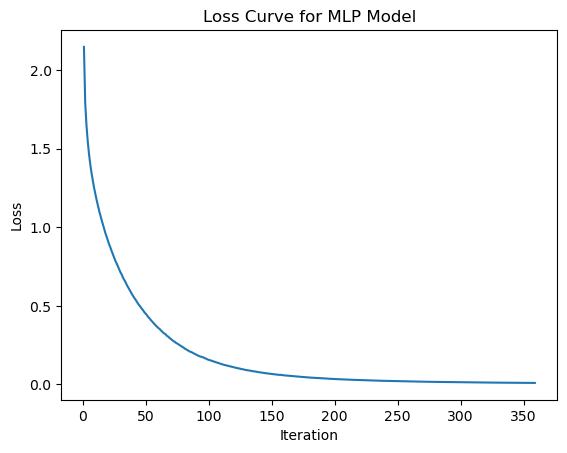

In [42]:
plt.figure()
plt.plot([num for num in range(1, model.n_iter_ + 1)], model.loss_curve_)
plt.title("Loss Curve for MLP Model")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

**Loss is indeed converging, and it appears to be a good learning rate - we want to avoid too high a learning rate since the model will bias data towards the last batches passed through it, and avoid too slow a learning rate because our model will take too long to converge.** Because of its perfect performance on the training data and poor performance on test data, we at this point suspect our model has too high a variance: It's learning to fit its weights so precisely to the training data to score well on it that its performance doesn't extend past that training data. If we had seen poor performance on both training and test sets, we would suspect our model to have a high bias.

**To solve high variance, wherein our model is overfitting to noise present in the training data, we can decrease the number of input features and/or increase the size of the training set** so our model has more data to learn on and can generalize better to data it has not seen. **We can also use data regularization, using data augmentation techniques such as the addition of random noise to the audio samples.** Data regularization is different from weight regularization, but they work towards the same purpose of reducing overfitting.

**To solve high bias, wherein our model is underfitting to the data, we could increase the number of input features** so that it can learn a better fit to the underlying data.

**High variance makes the model's predictions inconsistent**, while **high bias makes them inaccurate** and vice versa, respectively. Ultimately, we aim to make a model that is both accurate and consistent: low variance and low bias with good performance. There is almost always a trade-off between the two.


### The Confusion Matrix

A confusion matrix describes the performance of a classification model on test data. The axes of the matrix are labelled with all possible classes, in our case emotions - **the vertical levels/ columns represents predicted classes while the horizontal levels/rows represents the ground truth. The intersection of emotions on the matrix diagonal are correctly predicted labels.** All off-diagonal elements are incorrect predictions. We are literally checking to see where our model is confused, i.e. making incorrect predictions:


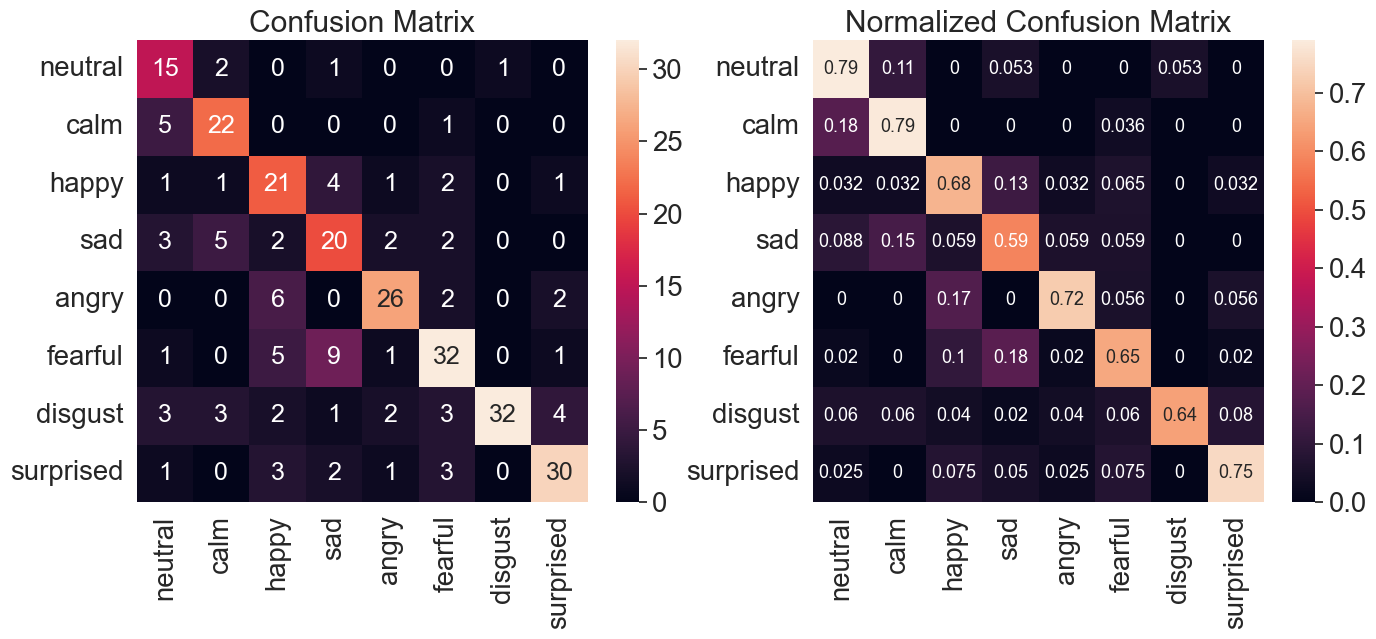

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sn  # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set
test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# set labels for matrix axes from emotions
emotion_list = [
    "neutral",
    "calm",
    "happy",
    "sad",
    "angry",
    "fearful",
    "disgust",
    "surprised",
]
emotion_name = [emotion for emotion in emotion_list]

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(
    test_emotion_groundtruth, test_emotion_predictions, labels=emotion_list
)
conf_matrix_norm = confusion_matrix(
    test_emotion_groundtruth,
    test_emotion_predictions,
    normalize="true",
    labels=emotion_list,
)


# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(
    conf_matrix_norm, index=emotion_name, columns=emotion_name
)

# plot confusion matrices
plt.figure(figsize=(16, 6))
sn.set(font_scale=1.8)  # emotion label and title size
plt.subplot(1, 2, 1)
plt.title("Confusion Matrix")
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18})  # annot_kws is value font
plt.subplot(1, 2, 2)
plt.title("Normalized Confusion Matrix")
sn.heatmap(
    confmatrix_df_norm, annot=True, annot_kws={"size": 13}
)  # annot_kws is value font

plt.show()

The sum of elements in the left matrix is size of our test set, which is the length of y_test. That should be 0.2\*1435 = 287. The matrix on the right shows each element as a percentage of samples in that class. Each row adds up to 100%, i.e. each row represents all samples of a particular emotion.

**We can tell the model is most accurate at predicting 'calm', and least accurate at predicting 'happy'**. Based on this we might look into our features to see where they are not distinct enough between confusing classes and whether we can rethink our feature engineering.


### Precision, Recall, F-Score

The confusion matrix is an intuitive measure of the precision and recall of our model w.r.t. each class. **Precision is a measure of how many positive predictions are true positives, and recall is a measure of how many positives we actually predicted from all positive samples in the dataset: Lower precision means we have more false positives, while lower recall means we have more false negatives.** For this dataset, precision of each emotion is how often we correctly predict it and recall is how many of that emotion we predicted out of all samples with that emotion in the dataset.

**Some tasks are more concerned with maximizing precision - minimizing false positives - such as predicting whether a prisoner is likely to reoffend if paroled.** It is [catastrophic](https://www.technologyreview.com/2019/01/21/137783/algorithms-criminal-justice-ai/) to deny an inmate parole due to a false positive.

**Some tasks are more concerned with maximizing recall - minimizing false negatives - such as predicting cancer risk from biomarkers.** It is better to inconvenience 10 people with a false positive test so we can catch the 1 true positive who would otherwise have been a false negative, rather than skip the 11 tests altogether (with 10 true negatives and 1 false negative).

**The [F-score](https://en.wikipedia.org/wiki/F1_score) is a weighted average of precision and recall when we are equally concerned with both metrics.**

**We can also make an [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#:~:text=A%20receiver%20operating%20characteristic%20curve,why%20it%20is%20so%20named.) by plotting True Positive vs False Positive Rate to visualize their trade-off and make considerations for further tuning.** However, ROC curves are usually plotted for binary classification; doing so for


In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
print(
    f"Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%"
)  # same as model.score(X_test, y_test)
print(
    f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%'
)
print(
    f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%'
)
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  68.990%
Test Set Precision score =  69.013%
Test Set Recall score =  70.077%
Test Set F-score score =  68.6%


**Pretty balanced across the board - about the same false positive rate and false negative rate.**


### K-Fold Cross-Validation

To highlight the importance of proper model validation and get a better idea of our model's performance,
we're going to use K-Fold Cross-Validation (K-Fold CV). We split our training dataset into _K_ unique validation sets (_K_ sets/folds) - the train/validation split being determined by _K_ where each _validation set = (100/K)%_ of the entire dataset, the training set being composed of the remaining _K-1_ validation sets. The term cross-validation refers to validating the model on multiple validation sets.

The terminology here may be somewhat confusing, because we usually **split our 80% _training_ set into a _training_ and _validation_ set at each iteration of K-Fold CV.** We reserve the actual _test_ set - the one we made originally with an 80/20 split of the entire dataset - for checking our model's performance _after_ we have tuned its hyperparameters.

In this way, K-Fold CV will train and score _K_ different versions of our classifier.
Note that while training sets overlap (unless otherwise defined, e.g. sklearn's GroupKFold), validation sets never overlap.
We'll use 10-fold CV, with _K=10_ being a choice giving average scores of models with fairly low bias and moderate variance due in part to the resulting 90/10 train/validation ratio.

**K-Fold CV trains our model on _K=10_ different, overlapping training folds and check its performance against _K=10_ validation folds.**

Smaller datasets would theoretically be better scored with **higher _K_,** meaning we will have a larger portion of our dataset in training sets and a greater overlap of training samples between folds - this way we better represent a small dataset, have more training data, and hopefully provide a **better estimate of the model's true generalization error**, though at the cost of **higher variance because the _K_ estimates of our model's performance are correlated** (though there are exceptions). In the extreme case, and for computationally inexpensive models, **leave-one-out K-Fold CV (LOOCV)** can be used to construct training folds consisting of all samples-1, and 1 sample with in the validation fold; _each training fold differs by just 1 sample_ and this method provides adequate training data for each model validation on smaller training datasets.

Sine we're training a classifier, we use **StratifiedKFold which preserves the percentage of samples in each class** (emotion) for each fold. Although we have a balanced dataset, Stratified K-Fold CV is especially important when classifying an imbalanced dataset. We also set shuffle=True to shuffle the order of sample classes in each fold to match the default behaviour of sklearn's train_test_split so we can accurately compare that to the K-Fold CV score.

Choose _K_ for our K-Fold CV and train the MLP classifier on each set of train/validation folds:


In [46]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, random_state=69, shuffle=True)

scores = []
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
for train_indices, test_indices in kfold.split(X_train, y_train):

    train_x = X_train.iloc[train_indices]
    train_y = y_train.iloc[train_indices]

    test_x = X_train.iloc[test_indices]
    test_y = y_train.iloc[test_indices]
    # fit model to training fold
    model.fit(train_x, train_y)
    # score the model on validation fold
    scores.append(model.score(test_x, test_y))

print("KFold CV scores for MLP:")
[print(f"{(100*score):.2f}%") for score in scores]
print(
    f"Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%"
)

KFold CV scores for MLP:
74.78%
66.09%
62.61%
63.48%
65.22%
61.74%
73.04%
66.09%
64.91%
71.93%
Mean score of KFold CV for MLP: 66.99% ± 4.36%


Indeed, quite a bit worse, but a more accurate evaluation of this model. **Because we get considerably worse performance fitting our model on random subsets of our training data, we could surmise that our model's performance is inflated by overfitting** when we train and test it just once on a regular 80/20 split.

Although K-Fold CV is computationally expensive, we're getting a lot more insight out of our data and that's a serious advantage when we have very few training samples. Tuning a model to just one validation set, such as in a 60/20/20 split may provide artifically inflated performance metrics which will disappoint when the model is applied to real-world data.


We can use a learning curve to compare the performance of our model if we had trained it on smaller subsets of our training dataset, and thus get an idea of whether we might expect a performance increase by using more training data, or much less likely that we don't need as much data.

We specify variable sizes of training sets to use for the learning curve to make one model for each size. Remember that since we're using 0.8\*1440 = 1152 samples in our training set, that is the upper bound that the learning curve can check for us. Like the validation curve, sklearn's learning curve implements Stratified K-Fold CV to evaluate multiclass classification models, so again we specify _K = 10_.


/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tigersu/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perce

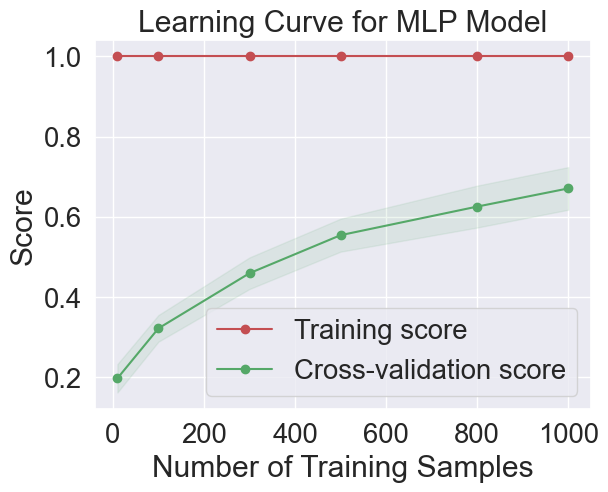

In [47]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    cv=10,
    shuffle=True,
    random_state=69,
    n_jobs=4,
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples
    train_sizes=[
        10,
        100,
        300,
        500,
        800,
        1000,
    ],  # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
plt.title("Learning Curve for MLP Model")
plt.xlabel("Number of Training Samples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

One thing the learning curve tells us is that the size of the dataset isn't our biggest issue - our **accuracy is plateauing and wouldn't seriously benefit from a larger training set** - maybe 5% at most with a gigantic dataset. Again, the gap between the training score curve and cross-validation score curve shows us that the model has an extremely high variance and - it scores perfectly on training data but poorly in cross-validation because it is seriously overfit - the model does not generalize well at all on test data.

It has become clear that an MLP network may not be the best choice of model for this task - it seems to not have the complexity we would need to properly discriminate the differences between our features w.r.t. emotion. It appears at this point that we would need a considerably more sophisticated deep neural net to get better performance on this dataset.


## Conclusion

The MLPClassifier is powerful in that it achieves appreciable performance with relatively little effort invested in exploratory analysis, hyperparameter optimization, and model architechture; especially taking advantage of grid search, and much more so when we know how to tune each hyperparameter individually.

We're going to have to explore more complicated deep learning methods to get real performance on this dataset. **Long-Short-Term-Memory Recurrent Neural Networks (LSTM RNNs) and Convolutional Neural Networks (CNNs) are excellent DNN candidates for audio data classification: LSTM RNNs because of their excellent ability to interpret sequential data such as the audio waveform represented as a time series; CNNs because features engineered on audio data such as spectrograms have marked resemblance to images, in which CNNs excel at recognizing and discriminating between distinct patterns.**

If you got this far, I sincerely appreciate your taking the time to do so. Feel free to drop a line at ilzenkov@gmail.com with any feedback you may have. HE isthe actual author of all these notebooks.
